In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [2]:
# load and process data for building 64
building_id = 64
subset_df = pd.read_csv('/Users/veronica/Library/CloudStorage/GoogleDrive-veronicahangsan@gmail.com/.shortcut-targets-by-id/1FsOPywSgK_wZmrVrSTBVi4q8G3Mg_yMJ/Team-Fermata-Energy/processed_data/subset20.csv')
processed_df = pd.read_csv(f'/Users/veronica/Library/CloudStorage/GoogleDrive-veronicahangsan@gmail.com/.shortcut-targets-by-id/1FsOPywSgK_wZmrVrSTBVi4q8G3Mg_yMJ/Team-Fermata-Energy/processed_data/processed_weather_load_w_timestamp/{building_id}.csv')

# normalize and inverse scaling
scaler = MinMaxScaler()
processed_df['scaled_energy_consumption'] = scaler.fit_transform(processed_df[['out.electricity.total.energy_consumption']])


In [3]:
def normalize(df, col_name):
    df[[col_name]] = scaler.fit_transform(df[[col_name]])
    return df

def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled)

In [4]:
# Prepare Data
processed_df = normalize(processed_df, 'out.electricity.total.energy_consumption')
load_data = processed_df['out.electricity.total.energy_consumption'].values

# Hyperparameters
window_size = 96  # 96 intervals = one day
num_days_to_predict = 7
X = []
y = []

In [5]:

# sliding window for a 96-interval forecast
for i in range(len(load_data) - 2 * window_size):
    X.append(load_data[i:i + window_size])  # input is the previous day
    y.append(load_data[i + window_size:i + 2 * window_size])  # target is the next day

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (34845, 96)
Shape of y: (34845, 96)


In [6]:
model = Ridge(alpha=1.0) 
model.fit(X, y)

# predicting for a week
predictions = []

# start with the last day in the training set
input_sequence = X[-1]

In [7]:
for day in range(num_days_to_predict):
    pred_day = model.predict(input_sequence.reshape(1, -1)).flatten()
    predictions.append(pred_day)
    
    # move window forward by using the latest prediction
    input_sequence = np.roll(input_sequence, -window_size)
    input_sequence[-window_size:] = pred_day
    
# reverse scaling
predictions_unscaled = inverse_transform(np.array(predictions).flatten().reshape(-1, 1)).flatten()

# plot
actual_data = inverse_transform(y[-num_days_to_predict:].flatten().reshape(-1, 1)).flatten()
predicted_data = predictions_unscaled


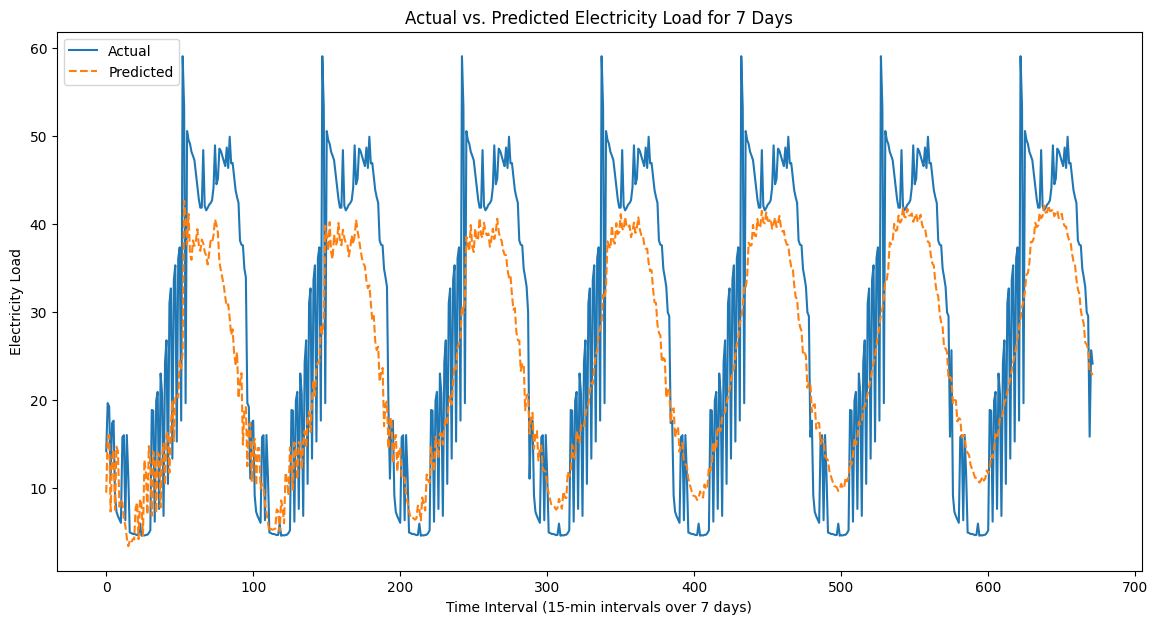

sMAPE: 38.23%


In [8]:
plt.figure(figsize=(14, 7))
plt.plot(actual_data, label="Actual")
plt.plot(predicted_data, label="Predicted", linestyle="--")
plt.xlabel("Time Interval (15-min intervals over 7 days)")
plt.ylabel("Electricity Load")
plt.title("Actual vs. Predicted Electricity Load for 7 Days")
plt.legend()
plt.show()

# sMAPE for each day
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

# Calculate sMAPE for the entire 7-day prediction
smape_value = smape(actual_data, predicted_data)
print(f"sMAPE: {smape_value:.2f}%")
